# Read Me

The [training](https://drive.google.com/file/d/1tfo6qm8zB5Eb7TY8WQGey-SqwBiC-3uO/view?usp=sharing) and [test](https://drive.google.com/file/d/1--yMo6lHVrkU9iqXUjLIJpKLYaz7QfLF/view?usp=sharing) data were downloaded from the [Zoo Galaxy](https://data.galaxyzoo.org/#section-21) platform, corresponding to Galaxy Zoo 2 ([images_gz2.zip](https://zenodo.org/records/3565489#.Y3vFKS-l0eY)).  

These data are already stored in ".h5" format instead of the original ".jpg" format to facilitate handling.  
The dataset consists of 10,000 files for training and 10,000 files for testing the model. Each file contains the information of 539,328 pixels (424x424x3) from the original ".jpg" image.  

Given the unmanageable amount of data (approximately 5$\times$10$^9$ pixels for training), it is necessary to reduce the dimensionality of the data.

To achieve this dimensionality reduction, the original images were first cropped to reduce background noise and emphasize the galaxy. Then, an IPCA model was trained, reducing the image size from (174,174,3) to (5,5,3).  

In addition to this reduction, another model was trained to rescale the values, ensuring compatibility with k-means clustering. Both models are [available](https://drive.google.com/drive/folders/1ZlEGFbrwHGSR0QaGgP5GbO-JOjR5FX9b?usp=sharing).

In an attempt to speed up data loading, the training and test data processed through the IPCA and SCALER models were saved as ".pkl" files. Both files are [available](https://drive.google.com/drive/folders/1XalRlt11sYmU11op2z3xPnVsRt8Pz0VM?usp=drive_link).

# Set up

## Packages

In [ ]:
# Mount Google Drive to access and store files
# Comment out this cell if running the script locally

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to ensure access


Mounted at /content/drive


In [ ]:
# Standard libraries for file handling, performance tracking, and data processing
import os                # File and directory management
import h5py              # Working with HDF5 file format
import time              # Measuring execution time
import random            # Random sampling
import pandas as pd      # Data handling and analysis
import numpy as np       # Numerical computations
import matplotlib.pyplot as plt  # Data visualization

# Machine learning tools for dimensionality reduction and preprocessing
from sklearn.decomposition import IncrementalPCA  # Incremental PCA for memory-efficient feature extraction
from sklearn.preprocessing import StandardScaler  # Standardizes features (zero mean, unit variance)
import joblib                                      # Saving and loading trained models and data


## Funtions

In [ ]:
def class_simplification(subclass):
    """
    Simplifies a subclass label to its main class label based on a predefined mapping.

    Parameters:
    - subclass (str): The detailed subclass label to be simplified.

    Returns:
    - str: The simplified main class label if matched, otherwise the original subclass.
    """

    # Mapping of detailed subclass labels to main class labels
    main_class = {
        "Ser": "Ser",
        "Seb": "Seb",
        "Sen": "Sen",
        "SB": "SB",
        "Sd": "Sd",
        "Sc": "Sc",
        "Sb": "Sb",
        "Sa": "Sa",
        "Er": "Er",
        "Ei": "Ei",
        "Ec": "Ec"
    }

    # Sort the keys of the dictionary by length in descending order to match longer prefixes first
    sorted_keys = sorted(main_class.keys(), key=len, reverse=True)

    # Iterate over the sorted keys to check for substring matches in the subclass label
    for key in sorted_keys:
        if key in subclass:  # Check if the key exists in any part of the subclass label
            return main_class[key]  # Return the main class label if a match is found

    return subclass  # Return the original subclass if no match is found


def load_data(root_data,log_data):
    """
    Loads and processes image data from HDF5 files, applies PCA transformation,
    and returns the transformed dataset.

    Parameters:
    - root_data (str): Path to the directory containing HDF5 files.

    Returns:
    - data (numpy array): Transformed dataset after PCA dimensionality reduction.
    """

    start_time = time.time()  # Start measuring execution time
    data = []  # List to store transformed data



    files_h5 = list(log_data['asset_id'])
    files_h5 = [str(f)+'.h5' for f in files_h5]

    total_files = len(files_h5)  # Total number of files
    crop = 125  # Cropping margin to remove edges from images

    # Process the first 500 images
    for i, img in enumerate(files_h5):

        # Open the HDF5 file and extract the galaxy image
        with h5py.File(os.path.join(root_data, img), 'r') as f:
            image = f["galaxy"][crop:-crop, crop:-crop].astype(np.float32) / 255  # Normalize image

            # Apply Incremental PCA transformation
            transformed = ipca.transform(image.reshape(1, -1))

            # Store the transformed image
            data.append(transformed)

        # Display progress updates every 100 files or at the last file
        if (i + 1) % 100 == 0 or (i + 1) == total_files:
            progress = (i + 1) / total_files * 100
            delta_t = time.time() - start_time
            print(f'Progress: {progress:.2f}%\nExecution time: {delta_t:.2f}s\n')

    # Convert the list of transformed data into a NumPy array
    data = np.vstack(data)

    return data

## Directories

In [ ]:
# Define the directories containing the HDF5 datasets for training, testing, and log data

root_train = '/content/drive/MyDrive/Practicas_Profesionales/Data/H5s/Train/'  # Path to training dataset
root_test = '/content/drive/MyDrive/Practicas_Profesionales/Data/H5s/Test/'    # Path to testing dataset
root_log_data = '/content/drive/MyDrive/Practicas_Profesionales/Data/Log_data/'  # Path to log data directory


## Log_data files

In [ ]:
# Load the training and testing metadata CSV files into Pandas DataFrames

log_data_train = pd.read_csv(root_log_data + 'log_data_train.csv')  # Load training data metadata
log_data_test = pd.read_csv(root_log_data + 'log_data_test.csv')    # Load testing data metadata

# Reduce dimensions

## show samples

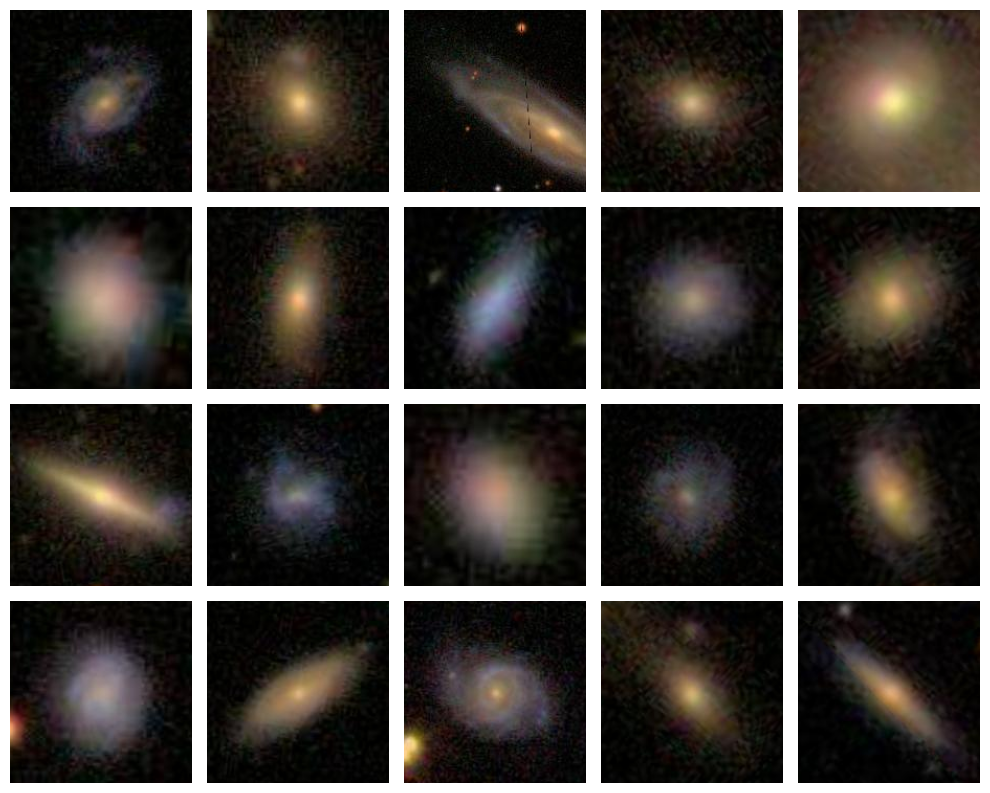

In [ ]:
# Display a 5x5 grid of randomly selected galaxy images from the training dataset
files_h5 = list(log_data_train['asset_id'])
files_h5 = [str(f)+'.h5' for f in files_h5]
plt.figure(figsize=(10, 10))  # Set figure size for better visibility

for i in range(20):  # Loop to display 25 random images
    sample = random.randint(0, len(files_h5))  # Select a random file from the training dataset

    root_file = os.path.join(root_train, files_h5[sample])  # Get the full path of the selected file
    # Open the HDF5 file and load the galaxy image
    with h5py.File(root_file, 'r') as f:
        crop = 125  # Pixels to crop from each side
        muestra = f["galaxy"][crop:-crop, crop:-crop]  # Extract the cropped image

    # Get image dimensions
    h, w, c = muestra.shape
    img_plana = h * w * c  # Compute flattened image size
    batch_size = 100  # Define batch size for Incremental PCA

    # Initialize Incremental PCA with 75 components
    ipca = IncrementalPCA(n_components=75, batch_size=batch_size)

    # Plot the image in a 5x5 grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(muestra)
    plt.axis('off')  # Remove axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('galaxies.jpg')  # Save the figure as an image
plt.show()  # Display the plot


## Training

In [ ]:
# Measure the start time for performance tracking
start_time = time.time()
total_file = len(files_h5)  # Total number of files to process

train_data = []  # List to store the final transformed dataset
batch = []  # Temporary batch for batch-wise processing

# Iterate over all HDF5 files in the training dataset
for i, img in enumerate(files_h5):
    root_file = os.path.join(root_train, img)  # Get the full file path

    # Open the HDF5 file and extract the galaxy image
    with h5py.File(root_file, 'r') as f:
        crop = 125                                                            # Number of pixels to crop from each side
        image = f["galaxy"][crop:-crop, crop:-crop].astype(np.float32) / 255  # Normalize image
        batch.append(image.reshape(1, -1))                                    # Flatten and store image in batch

    # Process the batch using Incremental PCA when batch size is reached
    if len(batch) == batch_size:
        batch_array = np.vstack(batch)    # Convert batch to a 2D NumPy array
        ipca.partial_fit(batch_array)     # Train Incremental PCA with the batch
        batch = []                        # Reset batch for the next iteration

    # Display progress update every batch_size iterations
    if (i + 1) % batch_size == 0:
        delta_t = time.time() - start_time                                    # Calculate elapsed time
        print(f'Progress: {np.round((i + 1) / total_file * 100, 2)}%')
        print(f'Elapsed time: {delta_t:.2f} s\n')
        batch.append(image.reshape(1, -1))                                    # Ensure last image is included in batch processing

# Transform the entire dataset using the trained Incremental PCA model
for img in files_h5:
    with h5py.File(os.path.join(root_train, img), 'r') as f:
        image = f["galaxy"][crop:-crop, crop:-crop].astype(np.float32) / 255  # Normalize
        transformed = ipca.transform(image.reshape(1, -1))                    # Apply PCA transformation
        train_data.append(transformed)                                        # Store transformed data

# Convert the final transformed dataset into a 2D NumPy array
train_data = np.vstack(train_data)


Progress: 1.0%
Elapsed time: 41.32 s

Progress: 2.0%
Elapsed time: 88.17 s

Progress: 3.0%
Elapsed time: 135.78 s

Progress: 4.0%
Elapsed time: 180.45 s

Progress: 5.0%
Elapsed time: 226.51 s

Progress: 6.0%
Elapsed time: 273.51 s

Progress: 7.0%
Elapsed time: 326.09 s

Progress: 8.0%
Elapsed time: 372.30 s

Progress: 9.0%
Elapsed time: 417.50 s

Progress: 10.0%
Elapsed time: 464.93 s

Progress: 11.0%
Elapsed time: 511.76 s

Progress: 12.0%
Elapsed time: 556.84 s

Progress: 13.0%
Elapsed time: 601.72 s

Progress: 14.0%
Elapsed time: 649.13 s

Progress: 15.0%
Elapsed time: 698.02 s

Progress: 16.0%
Elapsed time: 749.04 s

Progress: 17.0%
Elapsed time: 797.69 s

Progress: 18.0%
Elapsed time: 843.84 s

Progress: 19.0%
Elapsed time: 890.29 s

Progress: 20.0%
Elapsed time: 938.44 s

Progress: 21.0%
Elapsed time: 983.29 s

Progress: 22.0%
Elapsed time: 1030.57 s

Progress: 23.0%
Elapsed time: 1076.49 s

Progress: 24.0%
Elapsed time: 1122.79 s

Progress: 25.0%
Elapsed time: 1173.88 s

Progres

# Scaler data

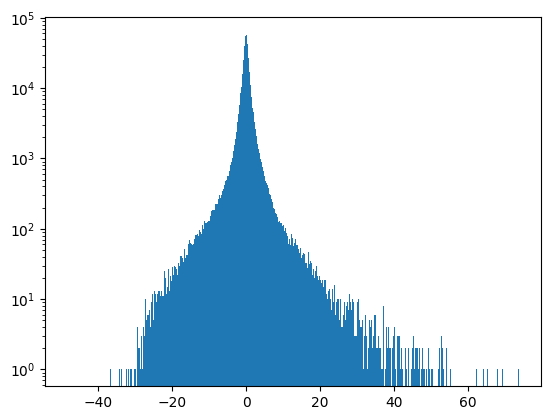

In [ ]:
# Flatten the training data array to a 1D array for histogram analysis
flat = train_data.flatten()

# Plot a histogram using a semi-logarithmic scale to visualize the distribution
plt.semilogy()  # Use a logarithmic scale for the y-axis to handle wide value ranges

# Create a histogram of the flattened training data
plt.hist(flat, bins=int(np.sqrt(len(flat))))  # Use the square root of the length for bin size

# Display the plot
plt.show()


In [ ]:
# Standardize the transformed dataset using StandardScaler
scaler = StandardScaler()                             # Initialize the scaler
Scaler_train_data = scaler.fit_transform(train_data)  # Apply standardization


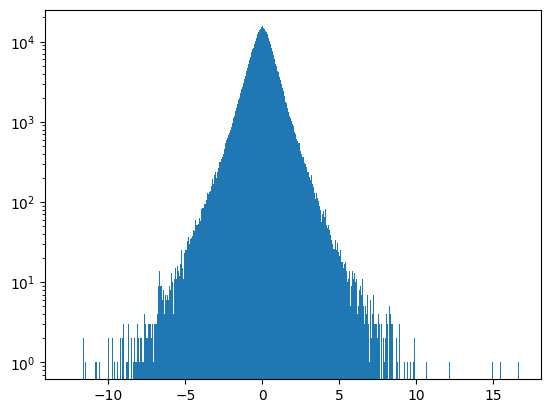

In [ ]:
# Create a histogram of the scaled training data to perform a sanity check

# Use a semi-logarithmic scale for the y-axis to visualize the distribution better
plt.semilogy()

# Plot a histogram of the flattened scaled training data
plt.hist(Scaler_train_data.flatten(), bins=int(np.sqrt(len(Scaler_train_data.flatten()))))

# Display the histogram
plt.show()


#Save models

In [ ]:
# Saves data preprocessing models
joblib.dump(ipca,'/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl')
joblib.dump(scaler,'/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl')

# Test models

## Load models

In [ ]:
# Load preprocessing models
ipca = joblib.load('/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl')
scaler = joblib.load('/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl')

## Load Data

In [ ]:
# Load the training data using the provided root directory and metadata
train_data = load_data(root_train, log_data_train)

# Apply the scaler to the training data to standardize the features
scaler_train = scaler.transform(train_data)

Progress: 1.00%
Execution time: 53.36s

Progress: 2.00%
Execution time: 108.51s

Progress: 3.00%
Execution time: 160.52s

Progress: 4.00%
Execution time: 214.13s

Progress: 5.00%
Execution time: 267.08s

Progress: 6.00%
Execution time: 318.76s

Progress: 7.00%
Execution time: 370.10s

Progress: 8.00%
Execution time: 420.70s

Progress: 9.00%
Execution time: 472.52s

Progress: 10.00%
Execution time: 523.02s

Progress: 11.00%
Execution time: 573.19s

Progress: 12.00%
Execution time: 624.25s

Progress: 13.00%
Execution time: 673.85s

Progress: 14.00%
Execution time: 723.51s

Progress: 15.00%
Execution time: 774.86s

Progress: 16.00%
Execution time: 826.14s

Progress: 17.00%
Execution time: 877.25s

Progress: 18.00%
Execution time: 927.40s

Progress: 19.00%
Execution time: 977.91s

Progress: 20.00%
Execution time: 1027.05s

Progress: 21.00%
Execution time: 1076.74s

Progress: 22.00%
Execution time: 1126.84s

Progress: 23.00%
Execution time: 1177.60s

Progress: 24.00%
Execution time: 1229.16

In [ ]:
# Load the test data using the provided root directory and metadata
test_data = load_data(root_test, log_data_test)

# Apply the scaler to the test data to standardize the features
scaler_test = scaler.transform(test_data)

Progress: 1.00%
Execution time: 85.76s

Progress: 2.00%
Execution time: 137.08s

Progress: 3.00%
Execution time: 189.28s

Progress: 4.00%
Execution time: 242.43s

Progress: 5.00%
Execution time: 294.04s

Progress: 6.00%
Execution time: 346.86s

Progress: 7.00%
Execution time: 399.52s

Progress: 8.00%
Execution time: 453.10s

Progress: 9.00%
Execution time: 505.09s

Progress: 10.00%
Execution time: 556.31s

Progress: 11.00%
Execution time: 608.41s

Progress: 12.00%
Execution time: 659.00s

Progress: 13.00%
Execution time: 710.95s

Progress: 14.00%
Execution time: 763.31s

Progress: 15.00%
Execution time: 815.25s

Progress: 16.00%
Execution time: 866.50s

Progress: 17.00%
Execution time: 920.83s

Progress: 18.00%
Execution time: 971.68s

Progress: 19.00%
Execution time: 1023.28s

Progress: 20.00%
Execution time: 1076.45s

Progress: 21.00%
Execution time: 1128.11s

Progress: 22.00%
Execution time: 1179.66s

Progress: 23.00%
Execution time: 1230.95s

Progress: 24.00%
Execution time: 1283.1

## Reconstruir Datos

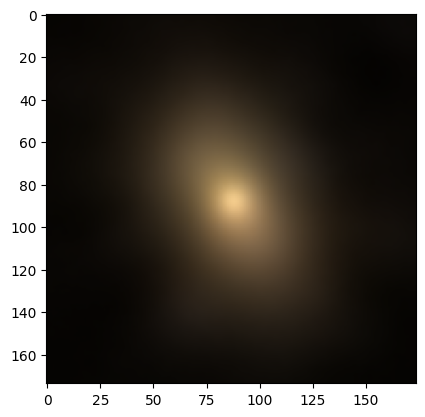

In [ ]:
# Reconstruct the original dataset using the inverse transformation from PCA
res_train_data = ipca.inverse_transform(train_data[:500])

# Reshape the reconstructed data to match the original image dimensions (assuming 500 images)
res_train_data = res_train_data.reshape(500, 174, 174, 3)  # (num_images, height, width, channels)

# Display one of the reconstructed images
plt.imshow(res_train_data[200])  # Show the 200th image


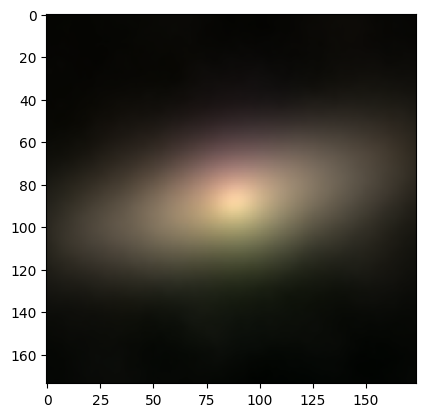

In [ ]:
# Reconstruct the original dataset using the inverse transformation from PCA
res_test_data = ipca.inverse_transform(test_data[:500])

# Reshape the reconstructed data to match the original image dimensions (assuming 500 images)
res_test_data = res_test_data.reshape(500,174,174,3)   # (num_images, height, width, channels)

# Display one of the reconstructed images
plt.imshow(res_test_data[435])   # Show the 200th image

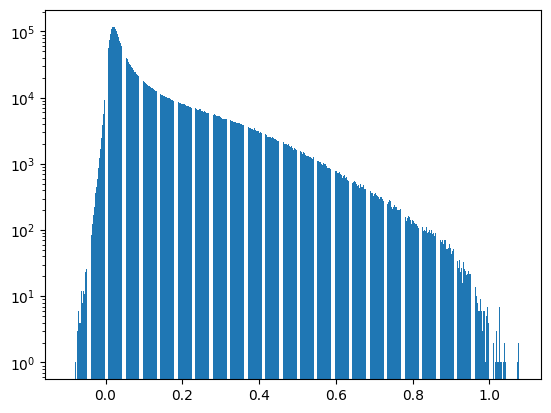

In [ ]:
# Use a semi-logarithmic scale on the y-axis for better visualization of frequency distribution
plt.semilogy()

# Plot a histogram of the flattened reconstructed training data
plt.hist(
    res_train_data.flatten(),  # Flatten the array to 1D to analyze pixel intensity distribution
    bins=int(np.sqrt(len(res_train_data.flatten()))),  # Use the square root rule for determining bin count
    rwidth=0.8  # Adjust bar width for better spacing and visibility
)

# Display the histogram
plt.show()


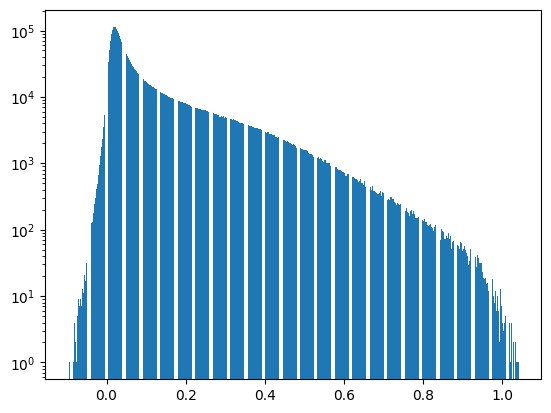

In [ ]:
# Use a semi-logarithmic scale for better visualization of the histogram
plt.semilogy()

# Plot a histogram of the flattened reconstructed test data
plt.hist(
    res_test_data.flatten(),  # Flatten the array to 1D for histogram calculation
    bins=int(np.sqrt(len(res_test_data.flatten()))),  # Use the square root rule for bin count
    rwidth=0.8  # Adjust bar width for better visibility
)

# Display the plot
plt.show()


# SAVE DATA (PKL)

To manage and load image information, PKL files are used. These files will store reduced and scaled information, that is, as 75-pixel images

In [ ]:
# Define file paths for saving the processed training and testing datasets in pickle format (PKL)

root_train_pkl = '/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/train_data.pkl'
root_test_pkl = '/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/test_data.pkl'


In [ ]:
# Save the processed training and testing datasets as pickle (.pkl) files using joblib

joblib.dump(scaler_train, root_train_pkl)   # Save the PCA-transformed training data
joblib.dump(scaler_test, root_test_pkl)     # Save the PCA-transformed test data


['/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/test_data.pkl']